In [1]:
import glob 
import os 
import librosa 
import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [2]:
# Load wav files
path_wav_files = '../lisTest/tcdDecision/playback/STIMULI/'
wav_folder_types = ['chinese','english']
wav_files = []

for i in range(len(wav_folder_types)):
    wav_files.append([])
    for file in glob.glob(path_wav_files+'/'+wav_folder_types[i]+'/wavFilesTest/'+'*'+'.wav'):
        wav_files[i].append(file)

In [3]:
# Extract MFCC features from wav files
fs = 16000
file_names_nspkrs1 = []
file_names_nspkrs2 = []
dist_nspkrs1 = []
dist_nspkrs2 = []

for j in range(len(wav_files)):
    
    file_names_nspkrs1.append([])
    file_names_nspkrs2.append([])
    dist_nspkrs1.append([])
    dist_nspkrs2.append([])
    
    for i in range(len(wav_files[j])):
        
        f = wav_files[j][i]
        y, sr = librosa.load(f, sr=None)
    
        # split speech sample at change point
        head, tail = os.path.split(f)
        change = tail.split('_')[2:4]
        t = int(change[0]) + 0.01*int(change[1])
        mfccs1 = librosa.feature.mfcc(y[:int(t*fs)], n_mfcc=40, sr=fs, hop_length=512)
        mfccs1_mean = np.mean(mfccs1, axis=1)
        mfccs2 = librosa.feature.mfcc(y[int(t*fs)+1:], n_mfcc=40, sr=fs, hop_length=512)
        mfccs2_mean = np.mean(mfccs2, axis=1)
        dist = np.linalg.norm(mfccs1_mean - mfccs2_mean)
        
        if tail.split('_')[5][0] == '1':
            file_names_nspkrs1[j].append(tail)
            dist_nspkrs1[j].append(dist)
        else:
            file_names_nspkrs2[j].append(tail)
            dist_nspkrs2[j].append(dist)

In [4]:
df_chin_nspkrs1 = pd.DataFrame()
df_chin_nspkrs1 = df_chin_nspkrs1.assign(file_name=file_names_nspkrs1[0], dist=dist_nspkrs1[0], reaction_times=0, count=0)
df_chin_nspkrs2 = pd.DataFrame()
df_chin_nspkrs2 = df_chin_nspkrs2.assign(file_name=file_names_nspkrs2[0], dist=dist_nspkrs2[0], reaction_times=0, count=0)

df_eng_nspkrs1 = pd.DataFrame()
df_eng_nspkrs1 = df_eng_nspkrs1.assign(file_name=file_names_nspkrs1[1], dist=dist_nspkrs1[1], reaction_times=0, count=0)
df_eng_nspkrs2 = pd.DataFrame()
df_eng_nspkrs2 = df_eng_nspkrs2.assign(file_name=file_names_nspkrs2[1], dist=dist_nspkrs2[1], reaction_times=0, count=0)

In [7]:
# Read human behavior data
audio_type = ['chin','eng']
sub_IDs = []
for i in range(2, 30):
    sub_IDs.append('S'+ str(i))
    

rt_chin_correct_nspkrs1 = []
rt_chin_correct_nspkrs2 = []
rt_eng_correct_nspkrs1 = []
rt_eng_correct_nspkrs2 = []


for i in range(len(sub_IDs)):
    for j in range(len(audio_type)):

        url = '../lisTest/tcdDecision/recordings/New_recordings/'+audio_type[j]+'_'+sub_IDs[i]+'/keys.csv'
        # load csv into a dataframe
        df = pd.read_csv(url,header=None,error_bad_lines=False)
        
    
        # extract the label (1/2), response (1/2), and session (TRAIN/TEST) columns
        indices = df[0].values
        filenames = df[1].values
        label = df[2].values
        resp = df[3].values
        session = df[4].values
        RT = (df[7].values - df[6].values)*1000 # in msec
    
        # get index of first TEST stimulus
        session = df[4].values
        for k in range(len(session)):
            if session[k] == 'TEST':
                indx_test = k
                break

    
        for k in range(indx_test,len(label)):
            # correct responses
            if int(label[k])==int(resp[k]):
                f = filenames[k]
                head, tail = os.path.split(f)
                nspkrs = int(tail.split('_')[5][0])
                if j==0:
                    if nspkrs==1:
                        temp = df_chin_nspkrs1.index[df_chin_nspkrs1['file_name']==tail].astype(int)
                        df_chin_nspkrs1.loc[temp, 'reaction_times'] += RT[k]
                        df_chin_nspkrs1.loc[temp, 'count'] += 1
                    else:
                        temp = df_chin_nspkrs2.index[df_chin_nspkrs2['file_name']==tail].astype(int)
                        df_chin_nspkrs2.loc[temp, 'reaction_times'] += RT[k]
                        df_chin_nspkrs2.loc[temp, 'count'] += 1
                else:
                    if nspkrs==1:
                        temp = df_eng_nspkrs1.index[df_eng_nspkrs1['file_name']==tail].astype(int)
                        df_eng_nspkrs1.loc[temp, 'reaction_times'] += RT[k]
                        df_eng_nspkrs1.loc[temp, 'count'] += 1
                    else:
                        temp = df_eng_nspkrs2.index[df_eng_nspkrs2['file_name']==tail].astype(int)
                        df_eng_nspkrs2.loc[temp, 'reaction_times'] += RT[k]
                        df_eng_nspkrs2.loc[temp, 'count'] += 1


In [8]:
df_chin_nspkrs1['mean_rt'] = df_chin_nspkrs1['reaction_times']/df_chin_nspkrs1['count']
df_chin_nspkrs2['mean_rt'] = df_chin_nspkrs2['reaction_times']/df_chin_nspkrs2['count']

df_eng_nspkrs1['mean_rt'] = df_eng_nspkrs1['reaction_times']/df_eng_nspkrs1['count']
df_eng_nspkrs2['mean_rt'] = df_eng_nspkrs2['reaction_times']/df_eng_nspkrs2['count']

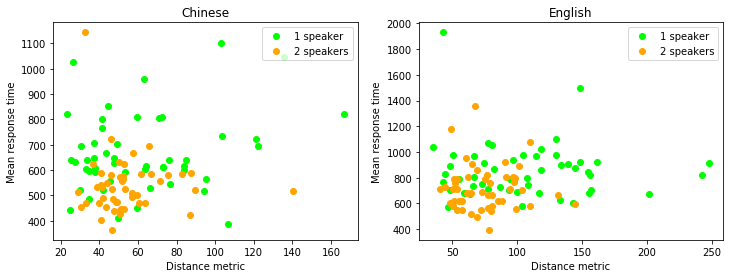

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax0, ax1 = axes.flatten()
ax0.plot(df_chin_nspkrs1['dist'].values, df_chin_nspkrs1['mean_rt'].values, 'o', color='lime')
ax0.plot(df_chin_nspkrs2['dist'].values, df_chin_nspkrs2['mean_rt'].values, 'o', color='orange')
ax0.set_xlabel('Distance metric')
ax0.set_ylabel('Mean response time')
ax0.set_title('Chinese')
ax0.legend(['1 speaker', '2 speakers'], loc='upper right')

ax1.plot(df_eng_nspkrs1['dist'].values, df_eng_nspkrs1['mean_rt'].values, 'o', color='lime')
ax1.plot(df_eng_nspkrs2['dist'].values, df_eng_nspkrs2['mean_rt'].values, 'o', color='orange')
ax1.set_xlabel('Distance metric')
ax1.set_ylabel('Mean response time')
ax1.set_title('English')
ax1.legend(['1 speaker', '2 speakers'], loc='upper right')